In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import string
import random
import datetime
import sys
import warnings
import pymysql
import pymysql.cursors
import uuid

In [2]:
query = """
SELECT FECHA,ID,
    SUM(IF(TECNOLOGIA='4G',USERS,0)) USERS_4G,
    SUM(IF(TECNOLOGIA='4G',ROUND(TRAFFICRG2/1024/1024),0)) TRAFFICRG2_4G,
    SUM(IF(TECNOLOGIA='4G',ROUND((UPLINK+DNLINK)/1024/1024),0)) TRAFFIC_4G,
    SUM(IF(TECNOLOGIA='3G',USERS,0)) USERS_3G,
    SUM(IF(TECNOLOGIA='3G',ROUND(TRAFFICRG2/1024/1024),0)) TRAFFICRG2_3G,
    SUM(IF(TECNOLOGIA='3G',ROUND((UPLINK+DNLINK)/1024/1024),0)) TRAFFIC_3G,
    SUM(IF(TECNOLOGIA='2G',USERS,0)) USERS_2G,
    SUM(IF(TECNOLOGIA='2G',ROUND(TRAFFICRG2/1024/1024),0)) TRAFFICRG2_2G,
    SUM(IF(TECNOLOGIA='2G',ROUND((UPLINK+DNLINK)/1024/1024),0)) TRAFFIC_2G
FROM
(
SELECT * FROM cdr_flow_sites_1day20200600
WHERE DATE(FECHA)>=DATE_SUB('2020-09-20',INTERVAL 12 WEEK) AND DATE(FECHA)<='2020-09-20'
AND ID='LI0271'
UNION ALL
SELECT * FROM cdr_flow_sites_1day20200700
WHERE DATE(FECHA)>=DATE_SUB('2020-09-20',INTERVAL 12 WEEK) AND DATE(FECHA)<='2020-09-20'
AND ID='LI0271'
UNION ALL
SELECT * FROM cdr_flow_sites_1day20200800
WHERE DATE(FECHA)>=DATE_SUB('2020-09-20',INTERVAL 12 WEEK) AND DATE(FECHA)<='2020-09-20'
AND ID='LI0271'
UNION ALL
SELECT * FROM cdr_flow_sites_1day20200900
WHERE DATE(FECHA)>=DATE_SUB('2020-09-20',INTERVAL 12 WEEK) AND DATE(FECHA)<='2020-09-20'
AND ID='LI0271'
) AA
GROUP BY FECHA,ID
ORDER BY FECHA
"""

In [3]:
connection = pymysql.connect(host='10.95.168.20',
                             user='admin',
                             password='',
                             db='cdr_flow_subscriber',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

with connection.cursor() as cursor:
        sql = query
        cursor.execute(sql)
        df = pd.DataFrame(cursor.fetchall())
connection.close()

In [4]:
date_time = pd.to_datetime(df.pop('FECHA'), format='%Y-%m-%d %H:%M:%S')
site = df.pop('ID')
df = df.astype(str).astype(float)

In [5]:
df.head()

,USERS_4G,TRAFFICRG2_4G,TRAFFIC_4G,USERS_3G,TRAFFICRG2_3G,TRAFFIC_3G,USERS_2G,TRAFFICRG2_2G,TRAFFIC_2G
0,3220.0,22246.0,61646.0,1891.0,2311.0,7169.0,134.0,20.0,38.0
1,2587.0,17299.0,44132.0,1337.0,1848.0,4909.0,131.0,40.0,51.0
2,2149.0,13533.0,32338.0,1015.0,1016.0,3409.0,100.0,13.0,20.0
3,1969.0,6550.0,19226.0,827.0,2116.0,4140.0,94.0,5.0,15.0
4,2017.0,3010.0,15077.0,817.0,2001.0,3219.0,99.0,6.0,11.0


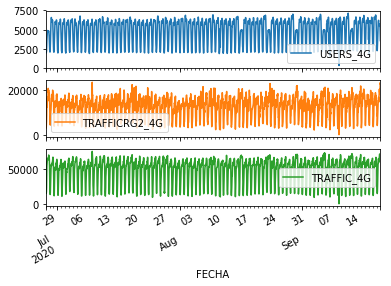

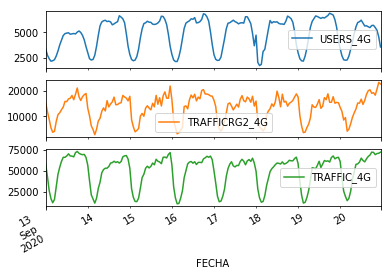

In [6]:
plot_cols = ['USERS_4G', 'TRAFFICRG2_4G', 'TRAFFIC_4G']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][1848:]
plot_features.index = date_time[1848:]
_ = plot_features.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
USERS_4G,2040.0,4768.675000,1537.976332,347.0,3337.00,5586.0,5982.50,7123.0
TRAFFICRG2_4G,2040.0,12546.386765,4677.116953,42.0,9022.00,13595.5,16089.00,23703.0
TRAFFIC_4G,2040.0,48253.618137,17790.977736,157.0,34863.00,55322.0,61385.50,76060.0
USERS_3G,2040.0,3028.711765,1262.247649,171.0,1722.50,3672.0,4076.00,4710.0
TRAFFICRG2_3G,2040.0,2058.020098,716.612684,166.0,1667.75,2135.0,2506.25,4985.0
TRAFFIC_3G,2040.0,5796.852941,1797.965492,407.0,4910.50,6290.5,6940.25,9771.0
USERS_2G,2040.0,185.974510,54.709858,15.0,135.75,203.0,227.00,653.0
TRAFFICRG2_2G,2040.0,24.106373,18.244241,1.0,11.00,19.5,33.00,137.0
TRAFFIC_2G,2040.0,59.224020,34.467238,1.0,32.00,57.0,81.00,206.0


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

In [9]:
split_time = 11*24*7
train_df = df[0:split_time]
val_df = df[split_time:]

num_features = df.shape[1]

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

# GETTING A SERIE

In [11]:
time = np.arange(len(df.index), dtype="float32")
x_train = np.array(train_df['USERS_4G'])
x_valid = np.array(val_df['USERS_4G'])
series = np.concatenate((x_train,x_valid), axis=0)

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    print(series)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    print(dataset)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    print(dataset)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    print(dataset)
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    print(dataset)
    dataset = dataset.batch(batch_size).prefetch(1)
    print(dataset)
    return dataset

# STARTING MODEL

In [14]:
window_size = 23
batch_size = 100
shuffle_buffer_size = 2000

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

[-0.99962364 -1.41065984 -1.69507351 ...  1.07308972  0.55036596
 -0.45871818]
<TensorSliceDataset shapes: (), types: tf.float64>
<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([]))>
<FlatMapDataset shapes: (None,), types: tf.float64>
<MapDataset shapes: ((None,), ()), types: (tf.float64, tf.float64)>
<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(23, input_shape=[window_size], activation="swish"),
    tf.keras.layers.Dense(10, activation="swish"),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)

In [17]:
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

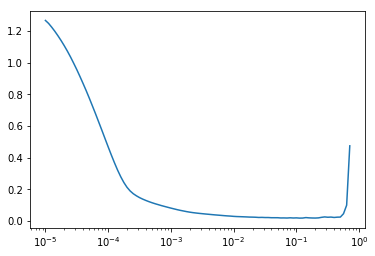

In [18]:
lrs = 1e-5 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])

# NEW LEARNING RATE

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(23, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [20]:
optimizer = tf.keras.optimizers.SGD(lr=5e-2, momentum=0.7)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=400, verbose=0)

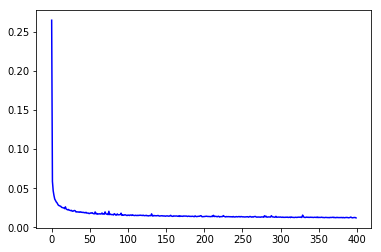

In [21]:
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

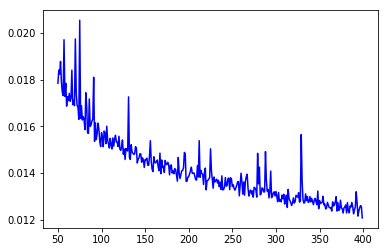

In [22]:
loss = history.history["loss"]
epochs = range(50, len(loss))
plot_loss = loss[50:]

plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [23]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

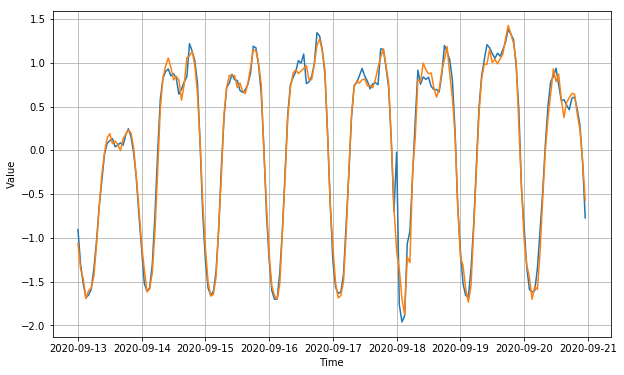

In [24]:
plt.figure(figsize=(10, 6))
plot_series(date_time[1848:], x_valid)
plot_series(date_time[1848:], results)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.08270601

# Recurrent neural network LSMT

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1.0)
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)

In [ ]:
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [ ]:
forecast = []
series = np.concatenate((x_train,x_valid), axis=0)

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)